In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00


In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import json
import plotly.express as px
from sklearn.model_selection import train_test_split # for splitting data into train and test samples
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Initialize a list to hold the data
data = []

# Specify the directory containing the labelled files
directory = "/content/drive/MyDrive/bank_run_detector_files/labelled/"

# Iterate over each file in the directory
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    # Check if the file is a JSON file
    if os.path.isfile(filepath) and filename.endswith('.json'):
        # Open and load the contents of the JSON file
        with open(filepath, 'r') as file:
            file_data = json.load(file)
            # For each item in the list, extract the 'text' and 'sentiment' and add to the data list
            for item in file_data:
                if 'text' in item and 'sentiment' in item:  # Ensure the keys exist
                    data.append({'text': item['text'], 'label': item['sentiment']})
            # # Extend the data list with the contents of this file
            # data.extend(file_data)

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(data)

In [ ]:
def update_label_names(df):
    # Define a mapping of old labels to new labels
    label_mapping = {
        "Risky": "Indicative of a Bank Run",
        "Non-risky": "Not Indicative of a Bank Run"
    }

    # Use the map function to update the 'sentiment' column based on the label_mapping
    df['label'] = df['label'].map(label_mapping)

    return df
df = update_label_names(df)
df.head()

,text,label
0,Too many candidates today to fit! Here's the ...,Not Indicative of a Bank Run
1,LATEST BANKING NEWS BNY Mellon Asset Servicing...,Not Indicative of a Bank Run
2,@SimonBTC right go to http://www.bnymellon.com...,Not Indicative of a Bank Run
3,BNY Mellon selected to provide corporate trust...,Not Indicative of a Bank Run
4,"New stock picks from @money magazine: $ABT, $W...",Not Indicative of a Bank Run


In [ ]:
df.label.value_counts()

Not Indicative of a Bank Run    1053
Indicative of a Bank Run          60
Name: label, dtype: int64

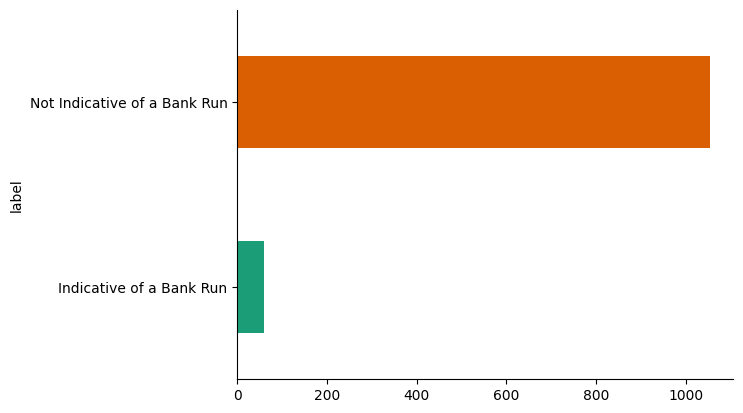

In [ ]:
# @title sentiment

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Desired number of majority samples after undersampling
desired_majority_samples = 180

# Filter the majority class
majority_class_df = df[df['label'] == "Not Indicative of a Bank Run"]

# Sample from the majority class to get the desired number of samples
undersampled_majority_df = majority_class_df.sample(n=desired_majority_samples, random_state=42)

# Combine the undersampled majority class with all instances of the minority class
df = pd.concat([df[df['label'] == "Indicative of a Bank Run"], undersampled_majority_df])

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


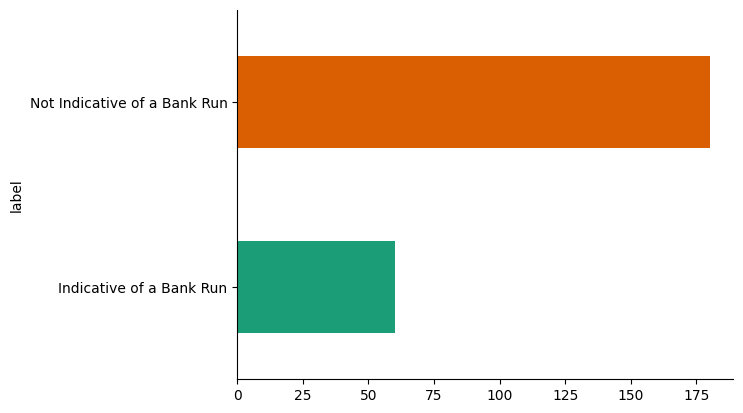

In [ ]:
# @title sentiment

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
X,y = df['text'], df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify = y)

In [ ]:
X_train.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace = True)
y_train.reset_index(drop=True, inplace = True)
y_test.reset_index(drop=True, inplace = True)

In [ ]:
df_train = pd.DataFrame(data = {'text': X_train, 'label': y_train})
df_train.head()

,text,label
0,Fifth Third Bank: had four separate accounts w...,Indicative of a Bank Run
1,@Chigz10AFC capital one are frauds! Still list...,Indicative of a Bank Run
2,RT 4 chance 2 win a $100 Fifth Third Bank gift...,Not Indicative of a Bank Run
3,Taneka Sukovaty liked NASDAQ:FITB $13.99 Fifth...,Not Indicative of a Bank Run
4,On Sun in LOU Hens broadcaster Jim Weber calle...,Not Indicative of a Bank Run


In [ ]:
df_test = pd.DataFrame(data = {'text': X_test, 'label': y_test})
df_test.head()

,text,label
0,$AADR - WCM/BNY Mellon Stock Analysis - free p...,Not Indicative of a Bank Run
1,Capital One Commercial with Jennifer Garner - ...,Not Indicative of a Bank Run
2,CFTC files complaint US Bank (US 5th largest b...,Indicative of a Bank Run
3,"Ethanol Safety Seminar Feb. 10th in Boston, MA...",Not Indicative of a Bank Run
4,#bearcatnation fuck Alabama @ Fifth Third Are...,Not Indicative of a Bank Run


In [ ]:
from datasets import Dataset

df_train = Dataset.from_pandas(df_train)
df_test = Dataset.from_pandas(df_test)

In [ ]:
from transformers import pipeline
from datasets import load_dataset


# Manually define the classes based on your dataset's labeling
classes = ["Indicative of a Bank Run", "Not Indicative of a Bank Run"]

# Set up the zero-shot classification pipeline from transformers
# Specify the FinBERT model you intend to use. Replace `your_finbert_model_here` with the actual model name or path.
pipe = pipeline("zero-shot-classification", model="ProsusAI/finbert")
zeroshot_preds = pipe(df_test['text'], batch_size=8, candidate_labels=classes)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [ ]:
finbert_probs = []
for pred in zeroshot_preds:
  if pred['labels'][0] == 'Indicative of a Bank Run':
    finbert_probs.append(pred['scores'][0])
  else:
    finbert_probs.append(pred['scores'][1])

In [ ]:
import numpy as np

preds = []
preds_proba = []

for pred in zeroshot_preds:
  preds.append(pred['labels'][0])
  preds_proba.append(pred['scores'][0])


In [ ]:
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]
for threshold in thresholds:
  print(f"Threshold: {threshold}")
  finbert_preds = []
  for i in finbert_probs:
    if i>= threshold:
      finbert_preds.append("Indicative of a Bank Run")
    else:
      finbert_preds.append("Not Indicative of a Bank Run")
  print(accuracy_score(df_test['label'], finbert_preds))
  print(classification_report(df_test['label'], finbert_preds))


Threshold: 0.2
0.2361111111111111
                              precision    recall  f1-score   support

    Indicative of a Bank Run       0.24      0.94      0.38        18
Not Indicative of a Bank Run       0.00      0.00      0.00        54

                    accuracy                           0.24        72
                   macro avg       0.12      0.47      0.19        72
                weighted avg       0.06      0.24      0.10        72

Threshold: 0.3
0.2777777777777778
                              precision    recall  f1-score   support

    Indicative of a Bank Run       0.25      0.94      0.40        18
Not Indicative of a Bank Run       0.75      0.06      0.10        54

                    accuracy                           0.28        72
                   macro avg       0.50      0.50      0.25        72
                weighted avg       0.62      0.28      0.18        72

Threshold: 0.4
0.4305555555555556
                              precision    recall  f

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
print(classification_report(df_test['label'], preds))

                              precision    recall  f1-score   support

    Indicative of a Bank Run       0.50      0.22      0.31        18
Not Indicative of a Bank Run       0.78      0.93      0.85        54

                    accuracy                           0.75        72
                   macro avg       0.64      0.57      0.58        72
                weighted avg       0.71      0.75      0.71        72

